In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from collections import defaultdict

In [2]:
# Define Permuted MNIST Dataset
class PermutedMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, permutations=None):
        self.mnist_dataset = torchvision.datasets.MNIST(root=root, train=train, transform=transforms.ToTensor(), download=True)
        self.transform = transform
        self.permutations = permutations
        self.train = train

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        if self.permutations is not None:
            image = image.view(-1)[self.permutations].view(image.shape)
        if self.transform:
            image = self.transform(image)
        return image, label

# Setup Permuted MNIST Tasks
num_tasks = 5
input_size = 28 * 28  # Flattened MNIST image
permutations = [torch.randperm(input_size) for _ in range(num_tasks)]

# Load Permuted MNIST Datasets for each task
train_tasks = [PermutedMNIST(root="./data", train=True, permutations=permutations[i]) for i in range(num_tasks)]
test_tasks = [PermutedMNIST(root="./data", train=False, permutations=permutations[i]) for i in range(num_tasks)]

# Function to create DataLoaders for each task
def get_task_data(task_idx, batch_size=64):
    train_loader = DataLoader(train_tasks[task_idx], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_tasks[task_idx], batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [10]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Function to train the model on a specific task
def train_task(model, task_idx, criterion, optimizer, epochs=5):
    train_loader, _ = get_task_data(task_idx)
    
    # For collecting metrics
    task_train_loss = []
    task_train_acc = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        task_train_loss.append(epoch_loss)
        task_train_acc.append(epoch_acc)
        
        print(f'Task {task_idx+1}, Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return task_train_loss, task_train_acc

# Function to evaluate the model on all seen tasks
def evaluate_all_tasks(model, num_tasks):
    accuracies = []
    
    for i in range(num_tasks):
        _, test_loader = get_task_data(i)
        
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Task {i+1} Accuracy: {accuracy:.2f}%')
    
    return accuracies

# Main function to demonstrate catastrophic forgetting
def demonstrate_catastrophic_forgetting():
    # Hyperparameters
    input_size = 28 * 28  # Flattened MNIST image
    hidden_size = 256
    output_size = 10  # 10 classes for Permuted MNIST
    learning_rate = 0.01
    epochs_per_task = 5
    
    # Initialize model
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # To store metrics
    training_history = {
        "task_accuracies": [],  # Performance on each task after sequential training
        "training_time": [],    # Time taken to train each task
        "learning_curves": {    # Loss and accuracy during training
            "loss": [],
            "accuracy": []
        }
    }
    
    # To compute forgetting metrics
    initial_accuracies = []  # Accuracy on each task right after learning it
    
    # Train on each task sequentially
    for task_idx in range(len(train_tasks)):
        print(f"\n{'='*50}")
        print(f"Training on Task {task_idx+1}")
        print(f"{'='*50}")
        
        # Measure training time
        start_time = time.time()
        
        # Train on current task
        task_loss, task_acc = train_task(model, task_idx, criterion, optimizer, epochs=epochs_per_task)
        
        # Record training time
        end_time = time.time()
        training_time = end_time - start_time
        training_history["training_time"].append(training_time)
        
        # Save learning curves
        training_history["learning_curves"]["loss"].extend(task_loss)
        training_history["learning_curves"]["accuracy"].extend(task_acc)
        
        # Evaluate on all tasks seen so far
        print("\nEvaluating on all tasks seen so far:")
        task_accuracies = evaluate_all_tasks(model, task_idx + 1)
        
        # Store the accuracy on the current task after learning it
        if task_idx == 0:
            initial_accuracies.append(task_accuracies[0])
        else:
            training_history["task_accuracies"].append(task_accuracies.copy())
            initial_accuracies.append(task_accuracies[task_idx])
    
    # Calculate forgetting metrics
    forgetting_rate = calculate_forgetting_metrics(training_history, initial_accuracies)

    plot_results(training_history, forgetting_rate, initial_accuracies)
    
    return training_history, forgetting_rate, initial_accuracies

# Function to calculate forgetting metrics
def calculate_forgetting_metrics(training_history, initial_accuracies):
    forgetting_rate = {}
    
    # For each task (except the last one since we don't have measurements after it)
    for task_idx in range(len(initial_accuracies) - 1):
        forgetting = []
        
        # Calculate forgetting for the task at each subsequent evaluation point
        for eval_idx, accuracies in enumerate(training_history["task_accuracies"]):
            if task_idx <= eval_idx:  # We only have measurements for tasks we've seen
                forgetting.append(initial_accuracies[task_idx] - accuracies[task_idx])
        
        forgetting_rate[f"Task {task_idx+1}"] = forgetting
    
    return forgetting_rate

def plot_results(training_history, forgetting_rate, initial_accuracies):
    # Set plotting style
    plt.style.use('ggplot')

    epochs_per_task = 5
    total_tasks = len(initial_accuracies)

    # 1. Loss learning curve
    plt.figure(figsize=(12, 5))
    plt.plot(training_history['learning_curves']['loss'], label='Training Loss', color='blue', marker='o')
    plt.title('Loss Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # 2. Accuracy by task plot
    plt.figure(figsize=(12, 5))
    for task_idx in range(total_tasks):
        start_idx = task_idx * epochs_per_task
        end_idx = start_idx + epochs_per_task
        task_acc = training_history['learning_curves']['accuracy'][start_idx:end_idx]
        task_epochs = range(start_idx + 1, end_idx + 1)
        plt.plot(task_epochs, task_acc, marker='o', label=f'Task {task_idx+1}')

    plt.title('Accuracy by Task (Epochs)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # 3. Task accuracies during sequential training
    plt.figure(figsize=(12, 5))
    for task_idx in range(total_tasks):
        task_accs = [acc[task_idx] if task_idx < len(acc) else None for acc in training_history['task_accuracies']]
        plt.plot(range(1, len(task_accs) + 1), task_accs, marker='o', label=f'Task {task_idx+1}')

    plt.title('Task Accuracies During Sequential Training')
    plt.xlabel('Training Progress (Tasks)')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # 4. Table of accuracies
    accuracy_table = pd.DataFrame(training_history['task_accuracies'], columns=[f'Task {i+1}' for i in range(total_tasks)])
    accuracy_table.index = [f'After Task {i+1}' for i in range(total_tasks -1 if len(training_history['task_accuracies']) >0 else 0)]
    print('\nTask Accuracies Table:\n')
    print(accuracy_table.to_string())

    # 5. Plotting forgetting rates
    plt.figure(figsize=(12, 6))
    for task_idx, forgetting in forgetting_rate.items():
        plt.plot(range(1, len(forgetting) + 1), forgetting, marker='o', label=f'{task_idx} Forgetting')
    plt.title('Forgetting Rates')
    plt.xlabel('Subsequent Tasks')
    plt.ylabel('Forgetting (Accuracy Drop)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Training on Task 1
Task 1, Epoch 1/5, Loss: 1.2265, Accuracy: 74.16%
Task 1, Epoch 2/5, Loss: 0.4920, Accuracy: 87.53%
Task 1, Epoch 3/5, Loss: 0.3923, Accuracy: 89.41%
Task 1, Epoch 4/5, Loss: 0.3525, Accuracy: 90.25%
Task 1, Epoch 5/5, Loss: 0.3281, Accuracy: 90.77%

Evaluating on all tasks seen so far:
Task 1 Accuracy: 91.46%

Training on Task 2
Task 2, Epoch 1/5, Loss: 0.6809, Accuracy: 81.79%
Task 2, Epoch 2/5, Loss: 0.3875, Accuracy: 89.35%
Task 2, Epoch 3/5, Loss: 0.3402, Accuracy: 90.47%
Task 2, Epoch 4/5, Loss: 0.3138, Accuracy: 91.12%
Task 2, Epoch 5/5, Loss: 0.2952, Accuracy: 91.61%

Evaluating on all tasks seen so far:
Task 1 Accuracy: 86.84%
Task 2 Accuracy: 92.17%

Training on Task 3
Task 3, Epoch 1/5, Loss: 0.6316, Accuracy: 82.25%
Task 3, Epoch 2/5, Loss: 0.3643, Accuracy: 89.72%
Task 3, Epoch 3/5, Loss: 0.3216, Accuracy: 90.87%
Task 3, Epoch 4/5, Loss: 0.2966, Accuracy: 91.56%
Task 3, Epoch 5/5, Loss: 0.2782, Accuracy: 92.05%

Evaluating on all tasks seen so far:
Task

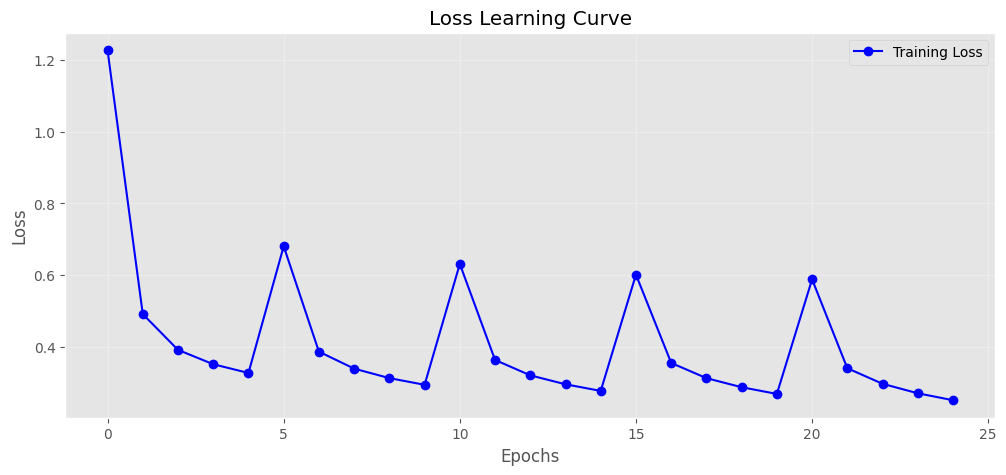

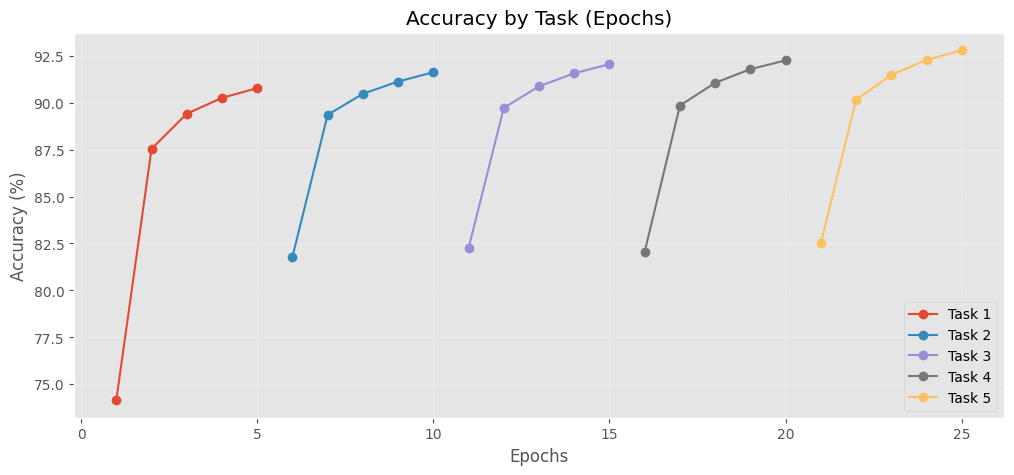

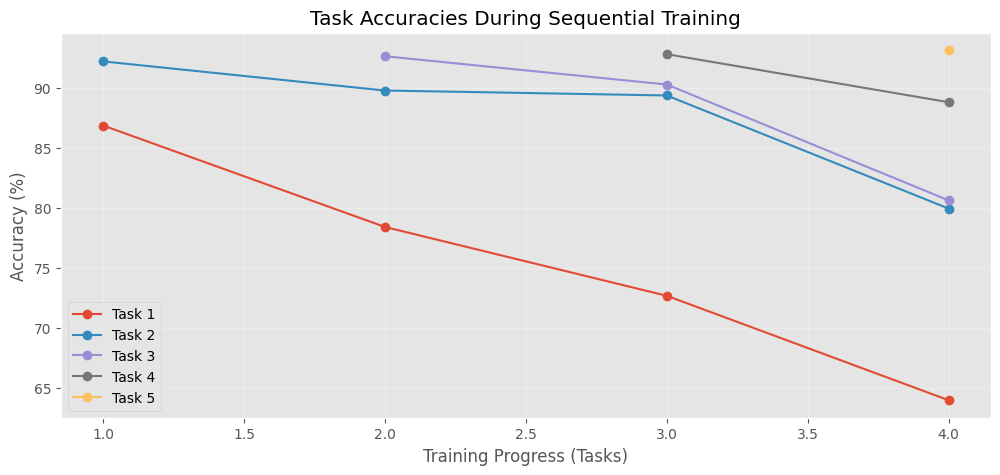

NameError: name 'pd' is not defined

In [11]:
# Example usage
if __name__ == "__main__":
    training_history, forgetting_rate, initial_accuracies = demonstrate_catastrophic_forgetting()